The purpose of this project is to understand and predict the relationship between medical insurance charges and the features.
https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset/code

# 1. Assesing:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [2]:
#reading in the data
df = pd.read_csv('insurance.csv')

In [3]:
missing_values_count = df.isnull().sum()
print(missing_values_count)


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [4]:
df.head()
print(df.shape)
df.info()

(1338, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# 2. Visualizing distributions
To understand distributions before modeling
* the historgrams for numerical
* the count plots for categorical

In [5]:
# loops to assess numerical columns automatically
numerical_features = []

# Iterate over each column
for col in df.columns:
    # Check if the column's data type is numerical
    if np.issubdtype(df[col].dtype, np.number):
        numerical_features.append(col)
print(numerical_features)

['age', 'bmi', 'children', 'charges']


In [6]:
# loops to assess numerical columns automatically

object_features= []

for col in df.columns:
    # Check if the column's data type is object (string)
    if df[col].dtype == 'object':
        object_features.append(col)

# Print the object columns found
print("Object columns:", object_features)

Object columns: ['sex', 'smoker', 'region']


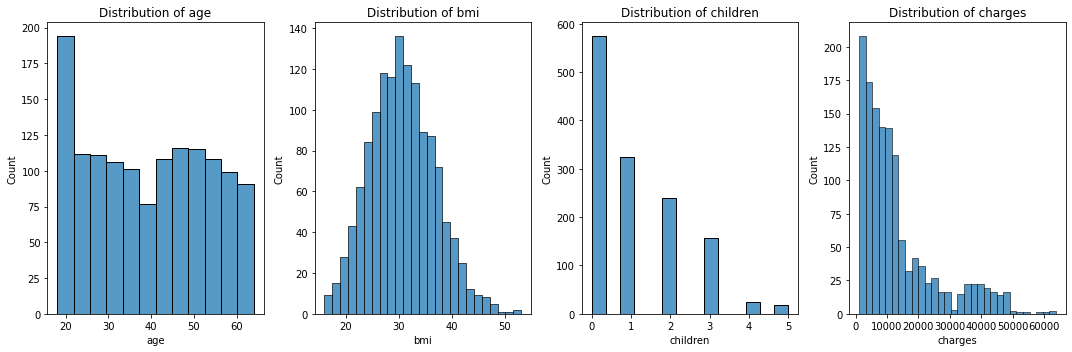

In [7]:
#Assign axis size, 1 puts all features on 1 row 
fig, axes = plt.subplots(1, len(numerical_features), figsize=(15, 5))

for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

Distribution of:
Age: primarily 0-20, other age groups distirbuted equally;
BMI: Bell curve around 30 yrs;
Children: mostly <1 yr;
Charges: most charges dropped < $10,000. Right Skew

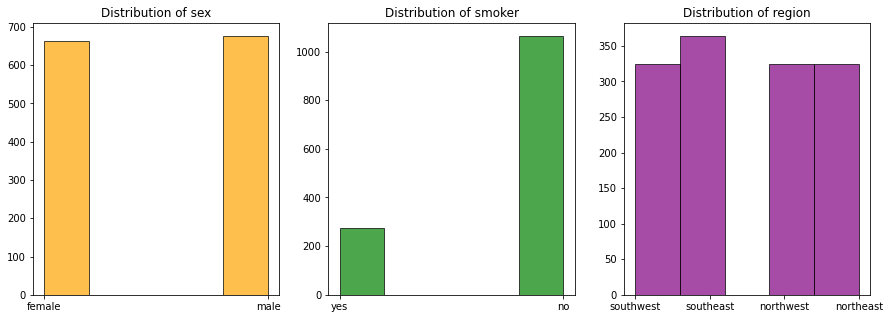

In [8]:
#Assign axis size
fig, axes = plt.subplots(1, len(object_features), figsize=(15, 5))

for i, feature in enumerate(object_features):
    values = df[feature]
    # Example: Define colors based on values (just a placeholder example)
    colors = ['orange', 'green', 'purple']

    # Plot histogram with specified colors
    axes[i].hist(values, bins=5, color=colors[i], edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Distribution of {feature}')

Distribution of: 
Sex: ~50/50 female male;
Smoker: 75% no **indicates importance by difference;
Region: all level

# 3. Bivariate Sampling 
- assess observations of two variables against each other

In [9]:
#lets make y charges, then classify the rest by how we want to visualize

numerical_continuous = ['age', 'bmi']
numerical_discrete =['children']
categorical_features  = ['region', 'smoker', 'sex']


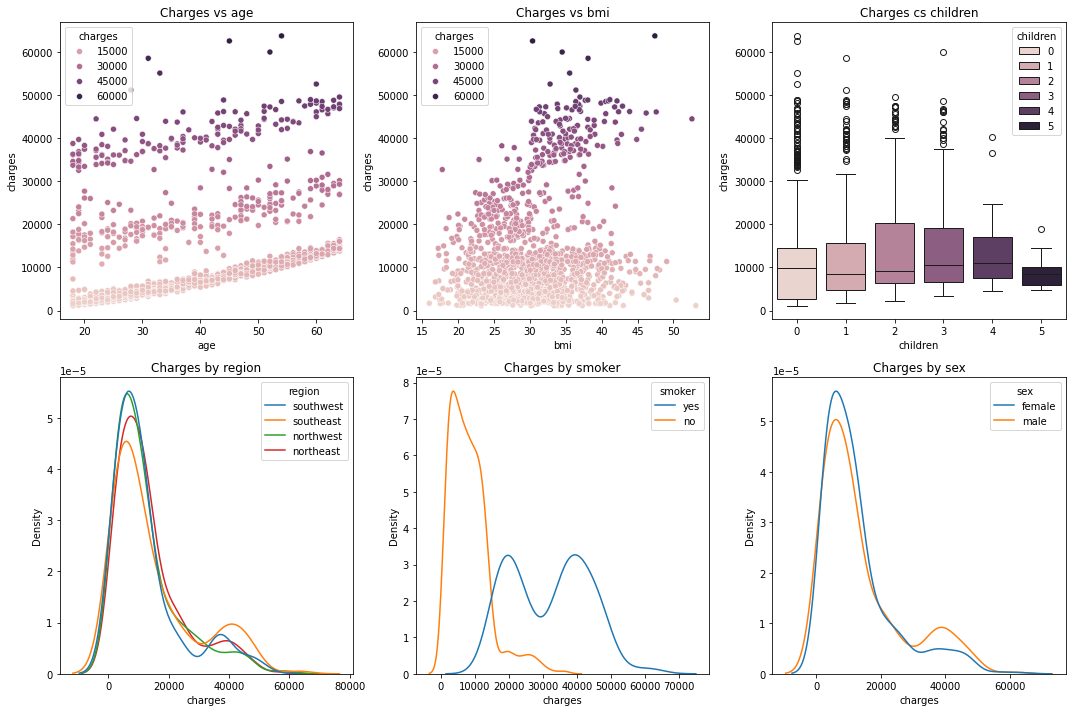

In [10]:
# define the axes meaning the amount of charts you want for all the bivariate visuals. So choose 2 rows of viz's by 3 columns totalling 6 visuals.
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

#Plot SCATTER - Continuous Numerical
for i, num in enumerate(numerical_continuous):
    sns.scatterplot(x=num, y='charges', data=df, hue = 'charges', ax=axes[0, i])
    axes[0, i].set_title(f'Charges vs {num}')

#Plot BOX - Discrete Numerical
for i, num in enumerate(numerical_discrete):
    sns.boxplot(x=num, y='charges', data = df, hue = 'children', ax=axes[0,2]) #refers to the subplot located in the first row, third column.
    axes[0,2].set_title(f'Charges cs {num}')

#Plot Line Graphs
for i, cat in enumerate(categorical_features):
    sns.kdeplot(x='charges', hue=cat, data=df, common_norm=False, ax= axes [1,i]) 
    axes[1,i].set_title(f'Charges by {cat}') #second row, all columns iterated over
    #common_norm=False means that each KDE plot (for each category defined by hue) = It allows for a clearer comparison of the distributions within each category defined by hue without influence of the density of the overall dataset
    #common_norm=True (default)= normalized KDE. total area under all KDE curves (across all categories) sums to 1, effectively scaling each individual KDE based on the overall density of all data points.
plt.tight_layout()
plt.show()

           

Smoker has a large impact on charge distribution. Next we will see how coupling smoking with the other features affects the outcomes. Particularly age and BMI seem to have independent trends that could be parsed out with smoker.


# 4. Multivariate Visualization

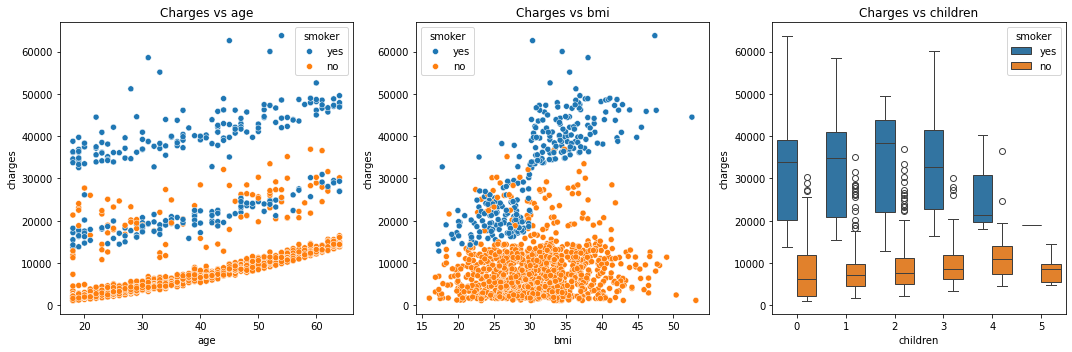

In [11]:
# Create a figure and axes to plot on
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#Loop through features to create visuals

#Plot SCATTER - Continous Numerical
for i, num in enumerate(numerical_continuous):
    sns.scatterplot(x=num, y='charges', hue='smoker', data = df, ax=axes[i])
    axes[i].set_title(f'Charges vs {num}')

#Plot BOX - Discrete Numerical 
for i, num in enumerate(numerical_discrete):
    sns.boxplot(x=num, y='charges', hue = 'smoker', data=df, ax=axes [2])#column 3
    axes[2].set_title(f'Charges vs {num}')

plt.tight_layout()
plt.show()

Charves vs Age:
The slopes of charges for yes and no look similar as age increases, they just start a lot lower for smoker = no. Smoker = Yes have two clusters one beginning around 20k charges and trending up with age, and one beginning around 35k and trending up with age. 

Charges vs BMI: 
The Smoker No charges trend below 20,000 except for outliers.
The Smoker Yes charge groups are parsed out by BMI as the charges cluster in the middle range for BMI <30 and cluster at higher charges for BMI > 30

Charges vs Children:
Charges for smokers trend higher than non smokers. The distribution is similar across all children groups except 4 and 5 due to lack of data points. The peak of distribution is at 2 children. 

# 5. Preprocessing the Data

In [12]:
df.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [13]:
#One hot encoding the categorical Features only
transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as is
)
# Features and target variable #works when in ssame block
X = transformer.fit_transform(df.drop(['charges'], axis=1))
y = df['charges']

In [14]:
# Split data into train and test sets. Test size 20% of the data, and random state ensures that there is random shuffling but you can reproduce your results each time by setting the randomness
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Decision Tree

Hyperparameters:
- max depth: complexity, if too complex then can over fit
- min_samples_split: min # of samples for an internal node to split. High # prevent the model from learning too specific patterns
- min_samples_leaf: min # of samples to be at the node. Controls overfitting, by ensuring each leaf has enough samples

The decision tree algorithm recursively splits the data based on the features (X_train) to minimize the mean squared error (in the case of DecisionTreeRegressor) between the predicted values and the actual target values (y_train).

In [15]:
# Initialize and fit decision tree model
tree = DecisionTreeRegressor(max_depth=10, min_samples_split=10, min_samples_leaf=10)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, min_samples_split=10)

In [16]:
# Predict on train data
y_pred_train = tree.predict(X_train)

# Predict on test data
y_pred_test = tree.predict(X_test)

MSE: Mean Squared Error the average of the differnce between predicted y and actual y. A low MSE indicates better model performance. *Squaring makes it sensitive

MAE: Absoulute difference between predicted and actuals =. Low MAE indicates better model. *Less sensitive to outliers bc no squaring. 

R^2: Coefficient of determination, measures how well the predictions of a regression model are to the actual data. Indicates variance between dependent and independent vars. 
* R2 = between 0 and 1. 
* A score closer to 1 indicates that the model explains a large proportion of the variance in the dependent variable.
* A score of 0 means the model does not explain any variance, and predictions are as good as predicting the mean of the observed data.
* A negative R2 score can occur if the model performs worse than predicting the mean.

In [17]:
# Evaluate model performance 

# Training data
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print('Training Metrics:')
print('RMSE:', rmse_train)
print('MAE:', mae_train)
print('R^2:', r2_train)

#Testing Data
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print('\nTesting Metrics:')
print('RMSE:', rmse_test)
print('MAE:', mae_test)
print('R^2:', r2_test)

Training Metrics:
RMSE: 4002.716002910175
MAE: 2281.9071121461766
R^2: 0.88899512680854

Testing Metrics:
RMSE: 4688.337037142829
MAE: 2672.490907915541
R^2: 0.8584174958298456


c:\Program Files\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


An R^2 close to 1 suggests a good fit of the model to the training data, too close to 1 would be an indicator of overfitting. 
The RMSE is appropriate since the charges are in the 10s of thousands
The testing data performs slightly worse compared to the training data

# 6. Visualize the Decision Tree

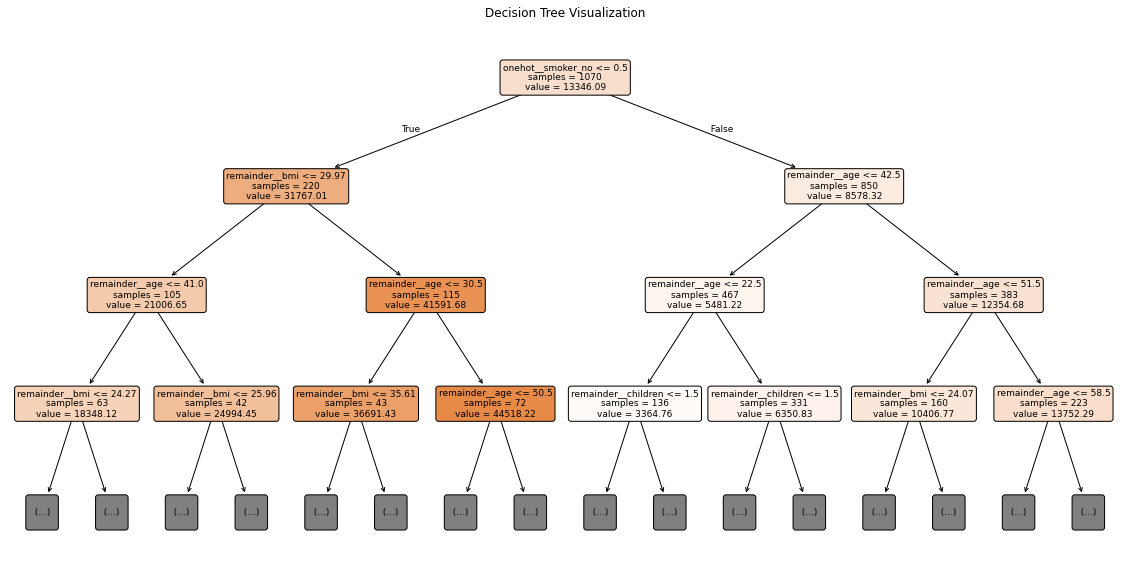

In [18]:
plt.figure(figsize=(20, 10))

#plot tree parameters
plot_tree(tree,
          feature_names=transformer.get_feature_names_out(),
          filled=True,
          rounded=True,
          precision =2,
          fontsize=9,
          max_depth=3,
          proportion=False,
          impurity=False
          )

plt.title("Decision Tree Visualization")
plt.show()

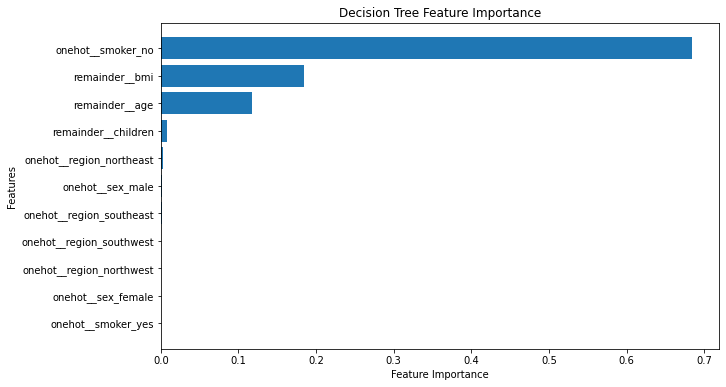

In [19]:
# Visualize the feature importance based on decision tree
importances = tree.feature_importances_
feature_names = transformer.get_feature_names_out()

#Sort by importance
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = feature_names[indices]

plt.figure(figsize=(10,6))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Decision Tree Feature Importance')
plt.gca().invert_yaxis()

plt.show()

# 7. Random Forest
* Combines models (decision trees) to improve predictive performance by creating more diversity in bootstrap and feature selection
* Less overfitting and more accuracy
* works with large data well

How: 
1. random forest builds multiple decision trees in training
2. Bagging/bootstrap aggregating/sampling: Each tree is trained independently using on a random sample with replacement of training data
3. Feature Selection: When splitting a node it selects a random subset of features


Compare Random Forest Statistics (R^2, rmse) to the Decision Tree Model to see improvement

In [20]:
# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [21]:
#Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [22]:
#Predict on train and test data
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

In [24]:
#Evaluate the Model 

#Evaluate Training
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print('Training Metrics')
print('RMSE:', rmse_train)
print('MAE:', mae_train)
print('R^2:', r2_train)

#Evaluate Testing
rmse_test = mean_squared_error(y_test, y_pred_test, squared = False)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print('Testing Metrics')
print('RMSE', rmse_test)
print('MAE:', mae_test)
print('R^2:', r2_test)

Training Metrics
RMSE: 1909.706505983429
MAE: 1042.2207628320336
R^2: 0.9747322980595288
Testing Metrics
RMSE 4613.653702363977
MAE: 2547.6696990447144
R^2: 0.862892274347087


c:\Program Files\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [31]:
#Prediction interval

Z=1.96

def random_forest_pred(rf, X):
    #create an array of each row representing a prediction of y from the input of vars x
    preds = np.array([tree.predict(X) for tree in rf.estimators_])

    y_mean = preds.mean(axis=0)
    var = preds.var(axis=0, ddof=1)
    return y_mean, var

#calculate the variance and standard error
y_mean_rf, var_rf = random_forest_pred(rf_model, X_test)
se_rf = np.sqrt(var_rf)

#plot the fit
df_rf = pd.DataFrame({'y': y_test, 'y_mean':y_mean_rf, 'se':se_rf, 'model':'clusterrf'})
df_rf['lower_ci']  = df_rf['y_mean'] - Z *df_rf['se']
df_rf['upper_ci'] = df_rf['y_mean'] + Z * df_rf['se']


Selected Features: ['onehot__smoker_no', 'onehot__smoker_yes', 'remainder__bmi', 'remainder__age', 'remainder__children']


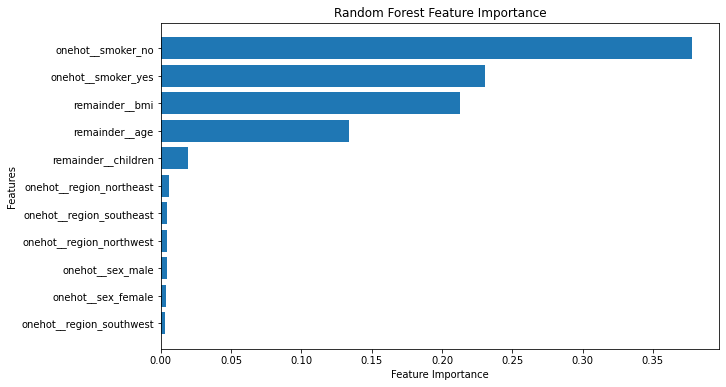

In [37]:
#assess the model for important features 

feature_names = transformer.get_feature_names_out()

importances = rf_model.feature_importances_

#DF with feature importances

feature_importances = pd.DataFrame({'Feature':feature_names, 'Importance': importances})

#sort teh data by importance
feature_importances = feature_importances.sort_values(by= 'Importance', ascending = False).reset_index(drop=True)


#select top 5 features (adjustable)
k = 5 

selected_features = feature_importances['Feature'][:k].tolist()

#print the selected featues
print('Selected Features:', selected_features)

#Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importances ['Feature'], feature_importances ['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis() # put the most important feature up top

plt.show()

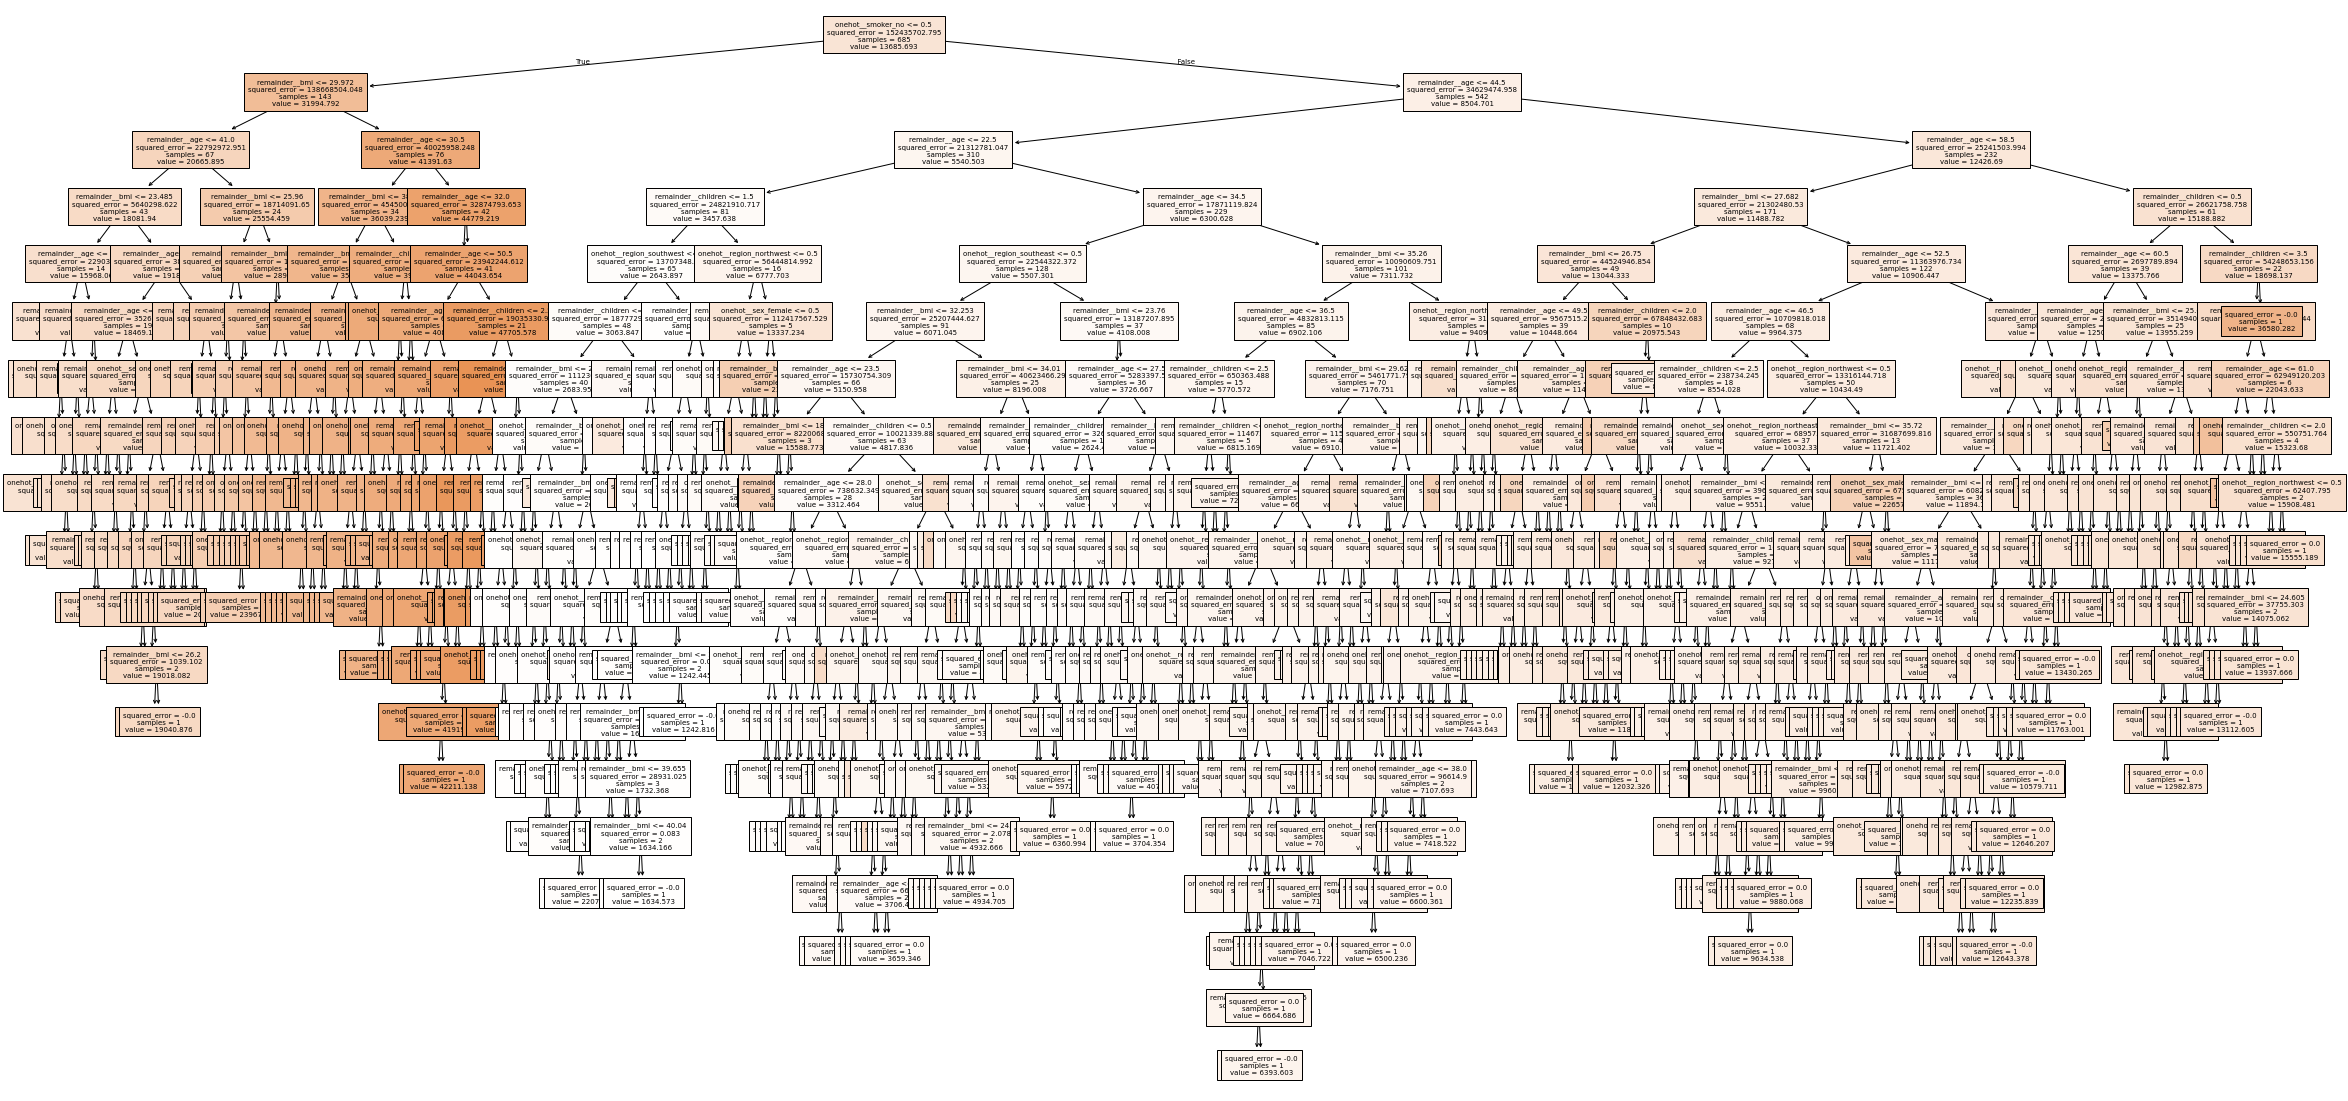

In [42]:
from sklearn.tree import plot_tree

# Plotting an individual tree (example for the first tree in the forest)
plt.figure(figsize=(40, 20))
plot_tree(rf_model.estimators_[0], feature_names=feature_names, filled=True, fontsize=7)
plt.show()

In [40]:
# Extract thresholds from individual trees
for i, tree in enumerate(rf_model.estimators_):
    tree_feature = tree.tree_.feature
    tree_threshold = tree.tree_.threshold
    
    print(f"Tree {i + 1} Important Nodes:")
    for j in range(tree.tree_.node_count):
        if tree_feature[j] != -2:  # -2 indicates a leaf node
            feature_name = feature_names[tree_feature[j]]
            threshold = tree_threshold[j]
            print(f"Node {j}: Feature '{feature_name}' with threshold {threshold:.2f}")

Tree 1 Important Nodes:
Node 0: Feature 'onehot__smoker_no' with threshold 0.50
Node 1: Feature 'remainder__bmi' with threshold 29.97
Node 2: Feature 'remainder__age' with threshold 41.00
Node 3: Feature 'remainder__bmi' with threshold 23.48
Node 4: Feature 'remainder__age' with threshold 26.50
Node 5: Feature 'remainder__bmi' with threshold 21.75
Node 6: Feature 'remainder__bmi' with threshold 19.38
Node 8: Feature 'remainder__bmi' with threshold 21.61
Node 10: Feature 'onehot__region_northeast' with threshold 0.50
Node 13: Feature 'onehot__region_southwest' with threshold 0.50
Node 14: Feature 'onehot__region_northeast' with threshold 0.50
Node 18: Feature 'remainder__bmi' with threshold 22.94
Node 19: Feature 'remainder__children' with threshold 0.50
Node 20: Feature 'onehot__region_northeast' with threshold 0.50
Node 23: Feature 'onehot__sex_male' with threshold 0.50
Node 24: Feature 'remainder__age' with threshold 28.00
Node 26: Feature 'remainder__age' with threshold 31.00
Node 3